# Predicting Voter Turnout Transitions in Sweden

**Machine Learning Analysis of Voting Behavior Change (2018-2022)**

Chi Nguyen | University of Gothenburg | November 2025

## Table of Contents

1. [Overview](#overview)
2. [Environment Setup](#setup)
3. [RQ1: Sampling Strategy and Data Scaling](#rq1)
4. [RQ2: Geographic Predictability](#rq2)
5. [RQ3: Explaining Municipal Variation](#rq3)
6. [Key Takeaways](#key-takeaways)
7. [Appendix](#appendix)

## 1. Overview <a id="overview"></a>

### 1.1 Research Objective

This project analyzes **changes in individual voting behavior** between Sweden’s 2018 and 2022 municipal elections using machine learning on the full population of voters (7.4 million). The focus is on transitions - who maintains voting habits, who stops, and who starts - rather than turnout in a single year.

### 1.2 Target Variable: Four Voting Patterns

| Pattern | Description | Prevalence |
|---------|-------------|------------|
| **VV** | Voted in both elections | 77% |
| **NN** | Did not vote in either election | 9% |
| **VN** | Voted in 2018 but not 2022 | 8% |
| **NV** | Voted in 2022 but not 2018 | 4% |

### 1.3 Covariates: Baseline Characteristics (measured in 2018)

**Numerical variables:**  
- `fgang18` — Indicator for being a first-time voter in 2018  
- `female` — Gender indicator  
- `age` — Age in 2018  
- `foreigner` — Indicator for having two foreign-born parents  
- `schooling_years` — Completed years of education  
- `share_sa` — Share of income from social assistance  
- `share_labor_income` — Share of income from labor earnings  
- `total_income` — Total annual income  
- `barn0_6`, `barn7_17`, `barn_above18` — Number of children in the household in each age group  

**Categorical variables:**  
- `birth_continent` — Continent of birth  
- `employment_status` — Employment category  
- `sector` — Employment sector  
- `marital_status` — Marital category  
- `Kommun` — Municipality (290 units)


### 1.4 Research Questions

**RQ1 – Sampling and Scaling:**  
How do balanced and stratified sampling perform across training sizes? Can very large datasets offset class imbalance?

**RQ2 – Geographic Patterns:**  
Which municipalities are more (or less) predictable, and what spatial patterns appear?

**RQ3 – Explanatory Analysis:**  
Which municipal characteristics help explain variation in predictability?

### 1.5 Notebook Structure

The notebook reports results produced in the secure MONA environment at Statistics Sweden. Each section follows a common structure:
1. Brief description of the analytical setup  
2. Key figures, and/or tables  
3. Interpretation of the main insights  

All visualizations are pre-generated from production runs using the full administrative data.


## 2. Environment Setup <a id="setup"></a>

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
from IPython.display import display

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

# File paths
results_dir = Path("outputs_mona")
tables_dir = results_dir / "tables"
plots_dir = results_dir / "plots"

---

## 3. RQ1: Sampling Strategy and Data Scaling <a id="rq1"></a>

### 3.1 Research Question

How do alternative sampling strategies perform as the training data size increases? Can very large training samples compensate for severe class imbalance?

### 3.2 Design

**Two-Phase Experimental Design:**

**Phase 1a (Method Comparison):** Head-to-head comparison where both strategies are feasible
- Training sizes: 100k, 200k, 400k, 800k
- Methods: Balanced vs. Stratified sampling
- Random seeds: 3 per configuration (12 total experiments)

**Phase 1b (Scaling Hypothesis):** Testing if stratified catches up with massive data
- Training sizes: 1M, 2M, 3M, 4M (stratified only)
- Random seeds: 3 per configuration (12 total experiments)

**Key Constraint:** Balanced sampling limited to 840k samples (smallest class = 210k × 4 classes)

### 3.3 Main Visualization: Two-Zone Performance Plot


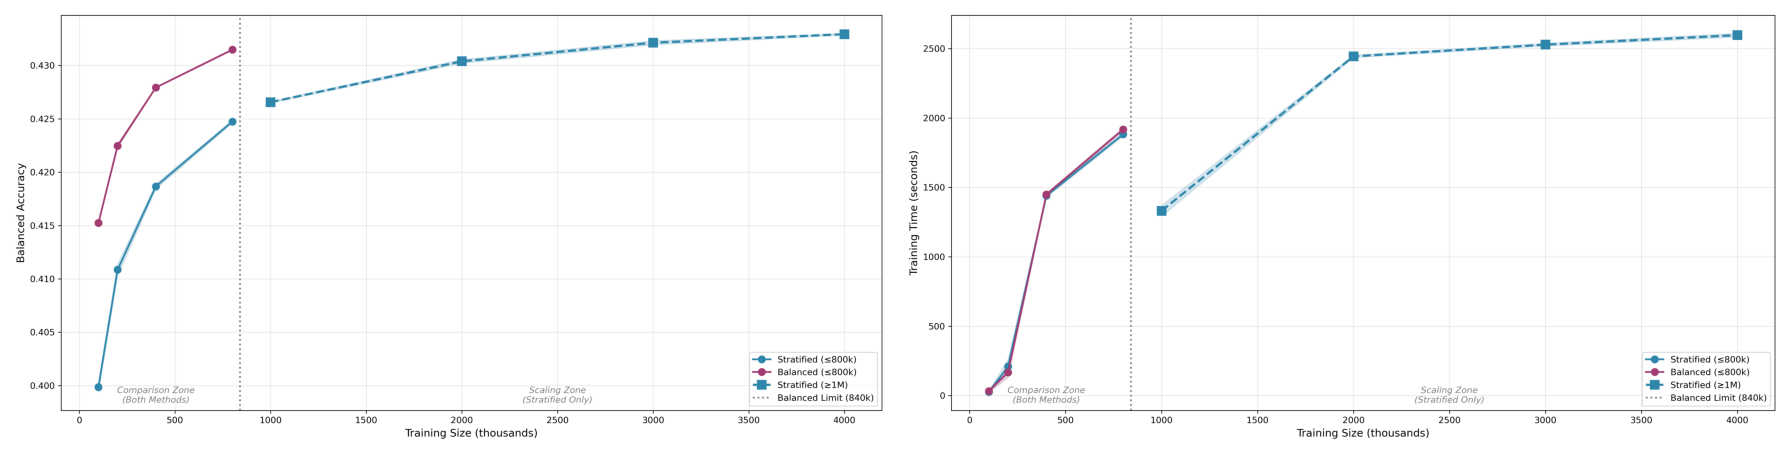

In [78]:
# Display diagnostic plots
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

plot_files = [
    "rq1_two_zone_balanced_accuracy.png",
    "rq1_two_zone_train_time.png",
]

for ax, fname in zip(axes, plot_files):
    img = mpimg.imread(plots_dir / fname)
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

### 3.4 Key Findings

**Comparison Zone (50k–800k)**  
- Balanced sampling outperforms stratified by roughly **0.5–1.5 percentage points**, with the largest gains at smaller training sizes.  
- The advantage reflects better coverage of minority outcomes, which stratified undersamples at low volumes.

**Scaling Zone (1M–4M)**  
- As training size increases, stratified sampling gradually closes the gap and slightly **surpasses** balanced sampling at the largest scales (≈0.433 vs. ≈0.431).  
- This comes with substantial computational cost: training time exceeds **2,500 seconds** beyond ~2M samples.

**Practical Takeaways**  
- **Below ~1M samples:** Balanced sampling is preferable.  
- **Above ~2M samples:** Stratified becomes competitive - use it if compute capacity is not a constraint.  
- Even with very large datasets, **class imbalance still affects performance**, so sampling strategy remains consequential.

### 3.5 Pareto Frontier: Choosing the "Best" Model

To identify a **benchmark model** for the rest of the analysis, I treat balanced accuracy and training time as a joint objective rather than optimizing either in isolation. Concretely, I construct the **Pareto frontier** over all RQ1 configurations:

- A configuration is **Pareto-dominated** if there exists another configuration with **at least as high balanced accuracy** and **no longer training time**, and strictly better on at least one of these dimensions.
- The **Pareto-efficient** configurations form a frontier of models that offer the best achievable trade-offs between predictive performance and computational cost.

Along this frontier, the **stratified model trained on 4 million observations** stands out as the preferred benchmark: it almost exhausts the available training sample and delivers the highest balanced accuracy among non-dominated models, while keeping training time within an acceptable range.

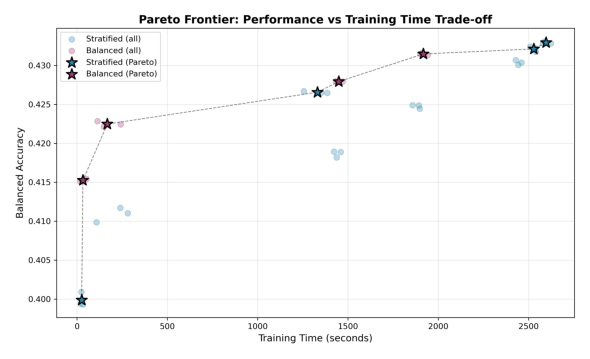

In [103]:
# Pareto frontier: balanced accuracy vs training time
fig, ax = plt.subplots(figsize=(6, 4))
img = mpimg.imread(plots_dir / "rq1_pareto_frontier.png")
ax.imshow(img)
ax.axis("off")
plt.tight_layout()
plt.show()

### Confusion Matrix — Best Model
<table>
  <thead>
    <tr>
      <th>True \ Predicted</th>
      <th>NN</th>
      <th>NV</th>
      <th>VN</th>
      <th>VV</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>NN</th>
      <td style="background-color:#b5deb7; text-align:center;">104,081<br><small>51.1%</small></td>
      <td style="background-color:#e0f3e1; text-align:center;">43,419<br><small>21.3%</small></td>
      <td style="background-color:#ecf6ec; text-align:center;">30,541<br><small>15.0%</small></td>
      <td style="background-color:#f2f8f2; text-align:center;">25,582<br><small>12.6%</small></td>
    </tr>
    <tr>
      <th>NV</th>
      <td style="background-color:#e7f4e8; text-align:center;">28,852<br><small>30.2%</small></td>
      <td style="background-color:#d4edd6; text-align:center;">32,908<br><small>34.5%</small></td>
      <td style="background-color:#f0f7f0; text-align:center;">12,259<br><small>12.8%</small></td>
      <td style="background-color:#e5f3e6; text-align:center;">21,432<br><small>22.5%</small></td>
    </tr>
    <tr>
      <th>VN</th>
      <td style="background-color:#e8f4e9; text-align:center;">48,898<br><small>28.3%</small></td>
      <td style="background-color:#eaf5eb; text-align:center;">41,820<br><small>24.2%</small></td>
      <td style="background-color:#ebf5ec; text-align:center;">40,179<br><small>23.2%</small></td>
      <td style="background-color:#eaf5eb; text-align:center;">41,950<br><small>24.3%</small></td>
    </tr>
    <tr>
      <th>VV</th>
      <td style="background-color:#f6faf6; text-align:center;">170,235<br><small>9.9%</small></td>
      <td style="background-color:#edf6ee; text-align:center;">307,985<br><small>18.0%</small></td>
      <td style="background-color:#f3f9f3; text-align:center;">201,221<br><small>11.8%</small></td>
      <td style="background-color:#6cbf70; text-align:center;">1,032,173<br><small>60.3%</small></td>
    </tr>
  </tbody>
</table>

The model performs strongly for voters who consistently turn out (<b>VV</b>), correctly
      classifying about <b>60%</b> of them. In contrast, the two transition groups (<b>NV</b> and
      <b>VN</b>) are much harder to predict: their true cases are spread across all four predicted
      categories, with no dominant pattern.
    </p>
    <p>
      This asymmetry highlights a broader theme in the results: static 2018 covariates capture
      persistent voting habits well but provide limited signal on who will <i>change</i> their voting
      behavior between elections.

---

## 4. RQ2: Geographic Predictability <a id="rq2"></a>

### 4.1 Research Question

Which Swedish municipalities have more predictable voting transitions? What geographic patterns emerge?

### 4.2 Design

- Use best model from RQ1 (trained on [4M samples with stratified sampling])
- Generate predictions on held-out test set
- Calculate municipality-level performance metrics
- Analyze spatial patterns across Sweden's 290 municipalities

**Metrics:**
- Balanced accuracy (primary metric)
- Per-class F1 scores
- Sample size (number of test observations per municipality)

### 4.3 Distribution of Predictability


In [100]:
# Load and summarize municipal predictability
rq2_results = pd.read_csv(tables_dir / "rq2_kommun_predictability.csv")

print("RQ2: Distribution of Balanced Accuracy Across Municipalities\n")
print(rq2_results['balanced_accuracy'].describe())

RQ2: Distribution of Balanced Accuracy Across Municipalities

count    290.0000
mean       0.4034
std        0.0235
min        0.3034
25%        0.3875
50%        0.4080
75%        0.4199
max        0.4553
Name: balanced_accuracy, dtype: float64


### 4.4 Geographic Pattern: Choropleth Map


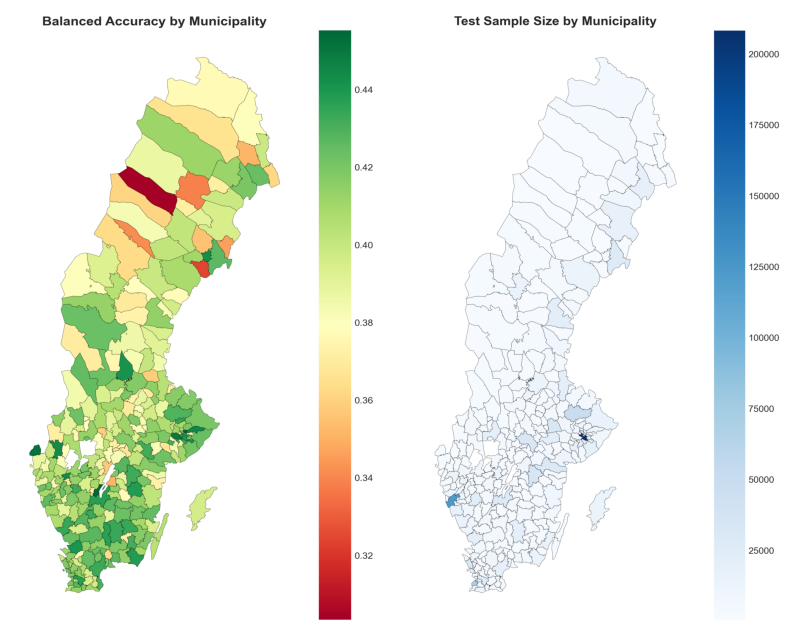

In [86]:
fig, axes = plt.subplots(1, 2, figsize=(10, 8))

plot_files = [
    "rq2_map_balanced_accuracy.png",
    "rq2_map_n_observations.png",
]

for ax, fname in zip(axes, plot_files):
    img = mpimg.imread(plots_dir / fname)
    ax.imshow(img, aspect='auto')   # <-- key change
    ax.axis('off')

plt.subplots_adjust(wspace=0.1)   # tighter horizontal spacing
plt.show()


---

## 5. RQ3: Explaining Municipal Variation <a id="rq3"></a>

### 5.1 Research Question

What municipal characteristics explain variation in predictability? Can we identify systematic patterns?

### 5.2 Analytical Framework

**Two Complementary Perspectives:**

1. **Task Complexity:** How challenging is the prediction problem?
   - Outcome diversity (Shannon entropy of voting patterns)
   - Sample size
   - Class balance (not presented here)

2. **Signal Strength:** How informative are the features? (Under construction)
   - Feature heterogeneity within municipality
   - Demographic diversity
   - Economic variation

### 5.3 Task Complexity: Outcome Diversity and Sample Size


#### 5.3.1 Initial Findings

**Outcome Diversity (Entropy)**  
- Higher entropy is associated with **lower** predictability, with a strong statistical signal.  
- Entropy alone accounts for only **~7%** of the variation in balanced accuracy.

**Sample Size (log n_test)**  
- Larger test samples correspond to **higher** balanced accuracy.  
- This relationship explains roughly **~24%** of the variation.

**Joint Model (Entropy + Sample Size)**  
- Both variables remain significant and keep their expected signs when included together.  
- The combined model explains **~29%** of the variation, meaning each contributes unique information.  
- Substantial unexplained variation remains, motivating a richer analysis of municipal characteristics next.


In [101]:
df = pd.read_csv(tables_dir / "rq3_regression_models.csv")

simple = (
    df[[
        "model",
        "predictors",
        "coef_entropy",
        "p_entropy",
        "coef_log_n_test",
        "p_log_n_test",
        "r2",
        "n_obs",
    ]]
    .rename(columns={
        "model": "Model",
        "predictors": "Predictors",
        "coef_entropy": "Coef (entropy)",
        "p_entropy": "p (entropy)",
        "coef_log_n_test": "Coef (log n_test)",
        "p_log_n_test": "p (log n_test)",
        "r2": "R²",
        "n_obs": "N",
    })
)

(simple.style
 .set_caption("Regression Models")
 .format({
     "Coef (entropy)": "{:.4f}",
     "Coef (log n_test)": "{:.4f}",
     "R²": "{:.3f}",
     "p (entropy)": "{:.3f}",
     "p (log n_test)": "{:.3f}",
 })
)


,Model,Predictors,Coef (entropy),p (entropy),Coef (log n_test),p (log n_test),R²,N
0,model1_entropy,entropy,-0.0679,0.000,nan,nan,0.067,290
1,model2_log_n_test,log(n_test),nan,nan,0.0118,0.000,0.239,290
2,model3_entropy_log_n_test,entropy + log(n_test),-0.0582,0.000,0.0114,0.000,0.287,290


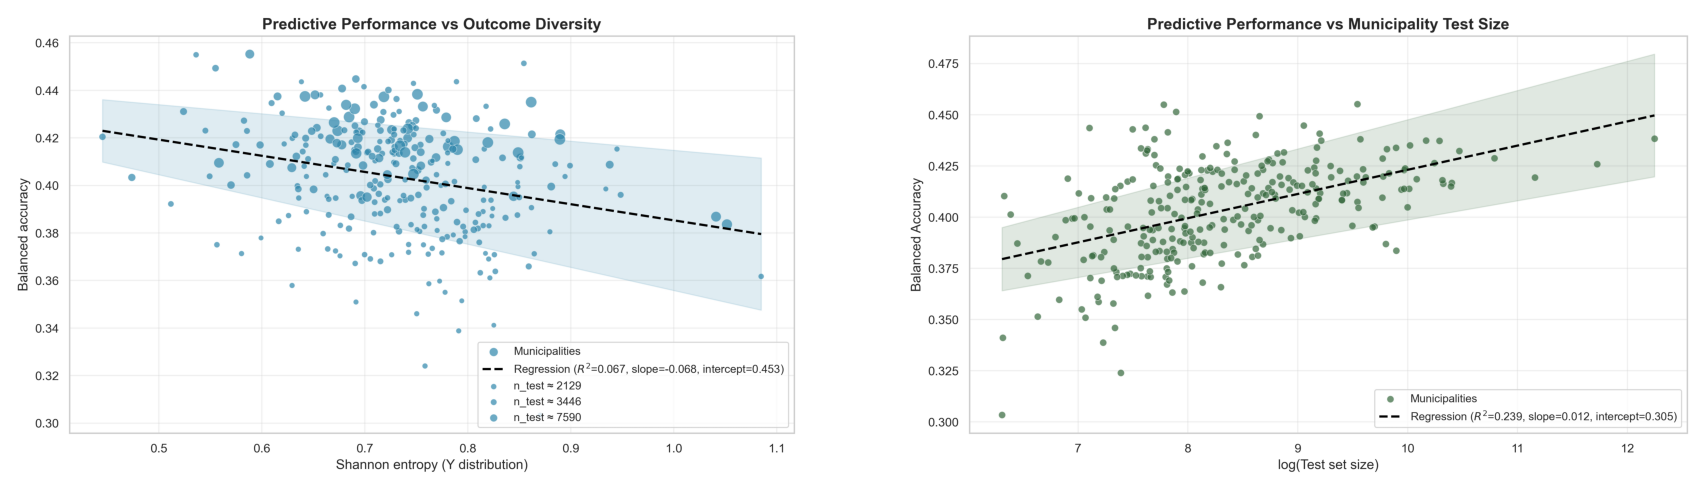

In [76]:
# Display diagnostic plots
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

plot_files = [
    "rq3_balacc_vs_entropy.png",
    "rq3_balacc_vs_logn_test.png",
]

for ax, fname in zip(axes, plot_files):
    img = mpimg.imread(plots_dir / fname)
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

### 5.4 Future Analysis

*Under development*

**Planned Extensions:**
- Feature-level heterogeneity analysis
- Composite signal strength indices
- Multiple regression with municipal characteristics

## 6. Key Takeaways <a id="key-takeaways"></a>

**Predictability Varies Substantially**  
- Municipal-level balanced accuracy ranges widely, reflecting real structural differences rather than noise alone.  
- Outcome diversity and sample size explain part of this variation but leave most of it unaccounted for.

**Data Scale Matters**  
- Balanced sampling clearly dominates at small and medium training sizes, while stratified sampling catches up and slightly surpasses it only at the very largest scales.  
- Training cost increases sharply in the upper range, making stratified sampling a high-compute option.

**Interpretation and Next Steps**  
- Predictive performance is shaped by both statistical factors (entropy, class imbalance) and underlying municipal characteristics.  
- The remaining unexplained variation motivates a deeper investigation into which local features drive predictability.

---

## 7. Appendix <a id="appendix"></a>

### Technical Specifications

**Model Configuration:**
- Algorithm: XGBoost Classifier
- Parameters: n_estimators=100, max_depth=6, learning_rate=0.1
- Feature handling: Native categorical support (`enable_categorical=True`)
- Evaluation metric: Balanced accuracy (primary), macro/weighted F1 (secondary)

**Data Split:**
- Training set: 70% (~4.9M observations)
- Test set: 30% (~2.2M observations)
- Random state: 42 (consistent across all experiments)
- Split method: Stratified by outcome class

**Computing Environment:**
- Production runs: Statistics Sweden MONA secure environment
- Development: Local machine with synthetic test data
- Code: Python 3.8+ with pandas, numpy, XGBoost, scikit-learn

### Data Sources

- Swedish electoral register (2018 and 2022 municipal elections)
- Complete population coverage (8.7M eligible voters)
- Administrative data accessed through Statistics Sweden
- All analyses conducted within secure computing environment

### Reproducibility

- All experiments use fixed random seeds (random_state=42)
- Same test set across all RQ1 experiments ensures fair comparison
- Modular code architecture documented on GitHub
- Results tables and figures exported from MONA for presentation

---

*Notebook version: 1.0 | Last updated: November 2025*